In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from statsbombpy import sb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, VerticalPitch,  Sbopen


### Usefull Functions

In [3]:
parser = Sbopen()
df, related, freeze, tactics = parser.event(3857300)
team_names = df["team_name"].unique()

In [4]:
hteam = team_names[0]
ateam = team_names[1]
print("Home Team : " + hteam)
print("Away Team : " + ateam)

home_df = df[df["team_name"] == hteam]
away_df = df[df["team_name"] == ateam]

Home Team : Argentina
Away Team : Saudi Arabia


# Overview da partida

## Posse de bola

In [5]:
duration_sum_by_team = df.groupby("team_name")["duration"].sum()
duration_sum_df = pd.DataFrame(duration_sum_by_team)
duration_sum_df.loc["Total"] = duration_sum_df.sum()
duration_sum_df = (duration_sum_df / 60).round(2)
duration_sum_df["Percentage"] = (duration_sum_df["duration"] / duration_sum_df.loc["Total", "duration"]).round(2) * 100
duration_sum_df


,duration,Percentage
team_name,,
Argentina,33.32,67.0
Saudi Arabia,16.18,33.0
Total,49.50,100.0


## Chutes

In [6]:
shots_table = df[df["type_name"] == "Shot"]

shots_pivot_updated = shots_table.pivot_table(
    index="outcome_name", 
    columns="team_name", 
    aggfunc="size", 
    fill_value=0
)

shots_pivot_updated.loc["Total"] = shots_pivot_updated.sum()

shots_pivot_updated_transposed = shots_pivot_updated.T
shots_pivot_updated_transposed

outcome_name,Blocked,Goal,Off T,Saved,Wayward,Total
team_name,,,,,,
Argentina,3,1,5,5,1,15
Saudi Arabia,1,2,0,0,0,3


C:\Users\Tobi\AppData\Local\Temp\ipykernel_14992\2478452956.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_a_df["Cumulative Shots"] = range(1, len(team_a_df) + 1)
C:\Users\Tobi\AppData\Local\Temp\ipykernel_14992\2478452956.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_b_df["Cumulative Shots"] = range(1, len(team_b_df) + 1)


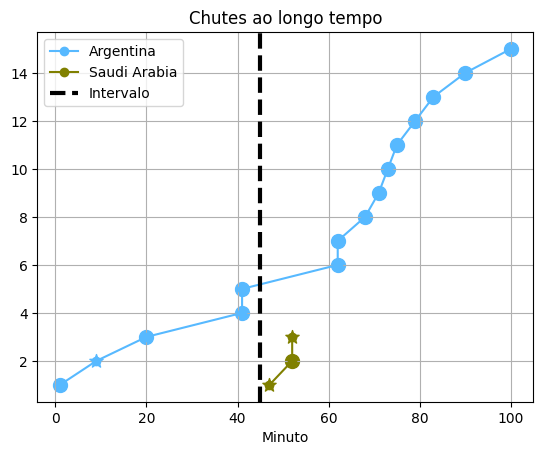

In [7]:
team_a_df = shots_table[shots_table["team_name"] == hteam]
team_b_df = shots_table[shots_table["team_name"] == ateam]

team_a_df["Cumulative Shots"] = range(1, len(team_a_df) + 1)
team_b_df["Cumulative Shots"] = range(1, len(team_b_df) + 1)

plt.plot(team_a_df["minute"], team_a_df["Cumulative Shots"], marker="o", linestyle="-", color="#57b9ff", label=hteam)

for i, row in team_a_df.iterrows():
    if row["outcome_name"] == "Goal":
        plt.scatter(row["minute"], row["Cumulative Shots"], marker="*", color="#57b9ff", s=100)
    else:
        plt.scatter(row["minute"], row["Cumulative Shots"], marker="o", color="#57b9ff", s=100) 


plt.plot(team_b_df["minute"], team_b_df["Cumulative Shots"], marker="o", linestyle="-", color="#808000", label=ateam)

for i, row in team_b_df.iterrows():
    if row["outcome_name"] == "Goal":
        plt.scatter(row["minute"], row["Cumulative Shots"], marker="*", color="#808000", s=100)
    else:
        plt.scatter(row["minute"], row["Cumulative Shots"], marker="o", color="#808000", s=100)

plt.title("Chutes ao longo tempo")
plt.xlabel("Minuto")
plt.axvline(x=45, color="black", linewidth=3, linestyle="--", label="Intervalo")
plt.legend()

plt.grid(True)

plt.show()


O gráfico acima demonstra dois grandes momentos de ineficiencia ofensiva da Argentina.

Os periodos entre 20-40 e do começo do segundo tempo até os 62 minutos

## Pressões

In [8]:
def classify_coordinate(x, y):
        if y <= 26.67:
            if x <= 40:
                return 1
            elif x <= 80:
                return 2
            else:
                return 3
                
        elif y <= 53.33:
            if x <= 40:
                return 4
            elif x <= 80:
                return 5
            else:
                return 6
                
        else:
            if x <= 40:
                return 7
            elif x <= 80:
                return 8
            else:
                return 9

def normalize_direction(x, y):
    max_x = 120
    max_y = 80

    return [max_x - x, max_y - y]


In [9]:
def plot_passes_and_pressure(counts, pressure_counts, percentages):
    pitch = Pitch(pitch_type="statsbomb", pitch_length=120, pitch_width=80, line_color="black")

    fig, ax = pitch.draw(figsize=(10, 6))

    regions = {
        1: {"xy": (0, 53.33), "width": 40, "height": 26.67}, 
        2: {"xy": (0, 26.67), "width": 40, "height": 26.67}, 
        3: {"xy": (0, 0), "width": 40, "height": 26.67},     
        
        4: {"xy": (40, 53.33), "width": 40, "height": 26.67},
        5: {"xy": (40, 26.67), "width": 40, "height": 26.67},
        6: {"xy": (40, 0), "width": 40, "height": 26.67},    
        
        7: {"xy": (80, 53.33), "width": 40, "height": 26.67}, 
        8: {"xy": (80, 26.67), "width": 40, "height": 26.67}, 
        9: {"xy": (80, 0), "width": 40, "height": 26.67}      
    }

    for i, region in regions.items():
        ax.add_patch(plt.Rectangle(**region, fill=True, color="lightblue", alpha=0.3, edgecolor="black"))
        
        center_x = region["xy"][0] + region["width"] / 2
        center_y = region["xy"][1] + region["height"] / 2
        
        total_passes = counts.get(i, 0)
        under_pressure = pressure_counts.get(i, 0)
        percentage = percentages.get(i, 0)

        ax.text(center_x, center_y, 
                f"Region Name: {i}\nTotal: {total_passes}\nPressure: {under_pressure}\n{percentage:.1f}%", 
                color="black", ha="center", va="center", fontsize=12, weight="bold")
        

    plt.show()

Normalizando ações de jogo, para que todas acões sejam contabilizadas da esquerda para direita

Argentina comecou atacando da esquerda para direita

In [10]:
condition = (home_df["period"] == 1)

home_df.loc[condition, ["end_x", "end_y"]] = home_df.loc[condition].apply(
    lambda row: normalize_direction(row["end_x"], row["end_y"]),
    axis=1,
    result_type="expand"
)

condition = (df["period"] == 2)

away_df.loc[condition, ["end_x", "end_y"]] = away_df.loc[condition].apply(
    lambda row: normalize_direction(row["end_x"], row["end_y"]),
    axis=1,
    result_type="expand"
)

In [11]:
home_df["field_third"] = home_df.apply(lambda row: classify_coordinate(row["end_x"], row["end_y"]), axis=1)
pass_counts = home_df[home_df["type_name"] == "Pass"].groupby("field_third")["type_name"].count().to_dict()
pass_counts_under_pressure = home_df[(home_df["type_name"] == "Pass") & (home_df["under_pressure"] == 1)].groupby("field_third")["type_name"].count().to_dict()

C:\Users\Tobi\AppData\Local\Temp\ipykernel_14992\4141877655.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_df["field_third"] = home_df.apply(lambda row: classify_coordinate(row["end_x"], row["end_y"]), axis=1)


In [12]:
percentages = {}

for field_third, total_passes in pass_counts.items():
    under_pressure_passes = pass_counts_under_pressure.get(field_third, 0)
    
    if total_passes > 0:
        percentage = (under_pressure_passes / total_passes) * 100
    else:
        percentage = 0
    
    # Store the percentage in the dictionary
    percentages[field_third] = percentage

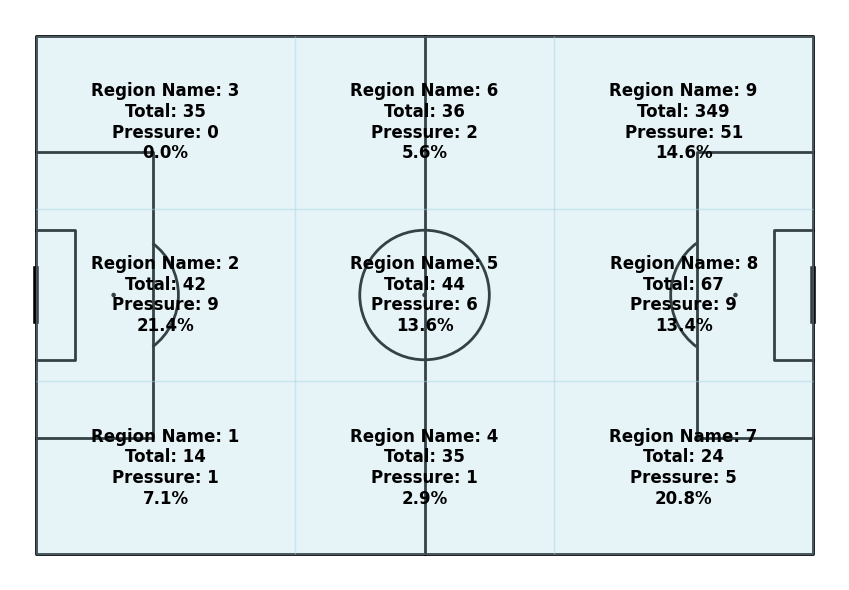

In [13]:
plot_passes_and_pressure(pass_counts, pass_counts_under_pressure, percentages)

In [14]:
presured_players = home_df[home_df["under_pressure"] == 1].groupby("player_name")["under_pressure"].count().sort_values(ascending=False)
presured_players

player_name
Lionel Andrés Messi Cuccittini     42
Ángel Fabián Di María Hernández    40
Alejandro Darío Gómez              36
Nahuel Molina Lucero               36
Rodrigo Javier De Paul             36
Lautaro Javier Martínez            28
Cristian Gabriel Romero            26
Nicolás Alejandro Tagliafico       21
Enzo Fernandez                     18
Leandro Daniel Paredes             13
Nicolás Hernán Otamendi            13
Lisandro Martínez                  11
Damián Emiliano Martínez            9
Marcos Javier Acuña                 6
Julián Álvarez                      5
Name: under_pressure, dtype: int64

A falta de pressão nas laterais do setor de transição indica que o time Saudita estava jogando com ambas linhas mais adiantadas, forçando a Argentina para as laterais do campo, mas oferecendo somente a zona de transição. Os obrigando a recuar a bola. Por outro lado a distribuição dos passes do time argentino indica que o método de ataque favorito, era o de criar vantagem numérica nas regiões do campo em que o Messi estava (4, 5, 7), método que foi combatido com a alta pressão saudita no setor, visto que dos 5 jogadores que mais sofreram pressões, 4 atuaram pelo lado direito do campo (Messi, Di Maria, Molina e De Paul)


In [15]:
condition = (home_df["under_pressure"] == 1) & (home_df["type_name"] == "Pass")

home_df["outcome_name"] = home_df["outcome_name"].fillna("Success")

passes_under_pressure = home_df[condition]

total_passes = passes_under_pressure.groupby("player_name")["outcome_name"].count()
incomplete_passes = passes_under_pressure[passes_under_pressure["outcome_name"] == "Incomplete"].groupby("player_name")["outcome_name"].count()

incomplete_percentage = (incomplete_passes / total_passes) * 100

pass_precision = pd.DataFrame({
    "Total Passes under presure": total_passes,
    "Incomplete %": incomplete_percentage
}).fillna(0) 
pass_precision


C:\Users\Tobi\AppData\Local\Temp\ipykernel_14992\2416185777.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_df["outcome_name"] = home_df["outcome_name"].fillna("Success")


,Total Passes under presure,Incomplete %
player_name,,
Alejandro Darío Gómez,10,10.000000
Cristian Gabriel Romero,7,14.285714
Damián Emiliano Martínez,4,25.000000
Enzo Fernandez,3,0.000000
Julián Álvarez,1,0.000000
Lautaro Javier Martínez,7,28.571429
Leandro Daniel Paredes,3,0.000000
Lionel Andrés Messi Cuccittini,8,12.500000
Lisandro Martínez,3,0.000000


## Ações do Messi

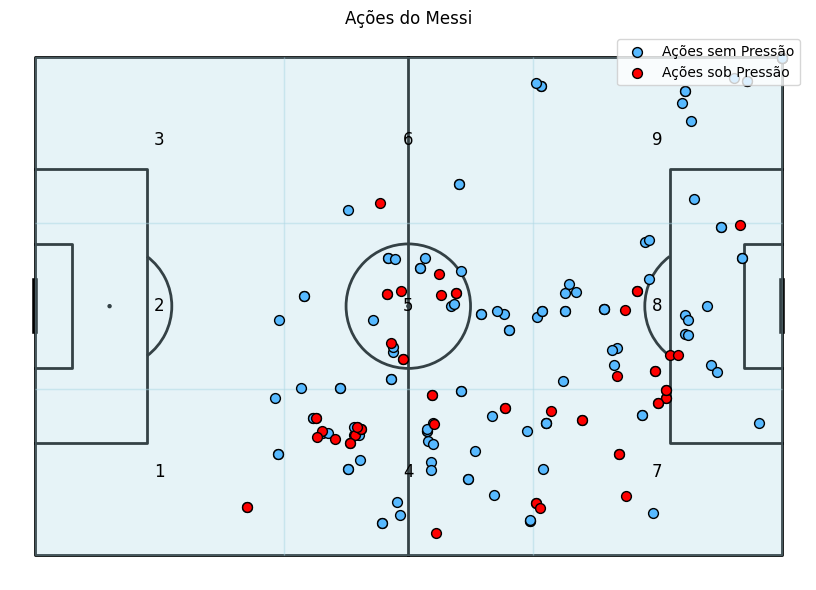

In [16]:
messi_actions = home_df[home_df["player_id"] == 5503]

messi_actions_under_pressure = messi_actions[messi_actions["under_pressure"] == 1]
messi_actions_no_pressure = messi_actions[messi_actions["under_pressure"] != 1]

pitch = Pitch(pitch_type="statsbomb", pitch_length=120, pitch_width=80, line_color="black")

fig, ax = pitch.draw(figsize=(10, 6))

regions = {
    1: {"xy": (0, 53.33), "width": 40, "height": 26.67}, 
    2: {"xy": (0, 26.67), "width": 40, "height": 26.67}, 
    3: {"xy": (0, 0), "width": 40, "height": 26.67},     
    4: {"xy": (40, 53.33), "width": 40, "height": 26.67},
    5: {"xy": (40, 26.67), "width": 40, "height": 26.67},
    6: {"xy": (40, 0), "width": 40, "height": 26.67},    
    7: {"xy": (80, 53.33), "width": 40, "height": 26.67}, 
    8: {"xy": (80, 26.67), "width": 40, "height": 26.67}, 
    9: {"xy": (80, 0), "width": 40, "height": 26.67}      
}    

for i, region in regions.items():
    ax.add_patch(plt.Rectangle(**region, fill=True, color="lightblue", alpha=0.3, edgecolor="black"))
    
    center_x = region["xy"][0] + region["width"] / 2
    center_y = region["xy"][1] + region["height"] / 2
    ax.text(center_x, center_y, str(i), ha="center", va="center", fontsize=12, color="black")

ax.scatter(messi_actions_no_pressure["x"], messi_actions_no_pressure["y"], color="#57b9ff", edgecolors="black", s=50, label="Ações sem Pressão")

ax.scatter(messi_actions_under_pressure["x"], messi_actions_under_pressure["y"], color="red", edgecolors="black", s=50, label="Ações sob Pressão")

plt.title("Ações do Messi")
plt.legend(loc="upper right")

plt.show()


## Ações dos laterais

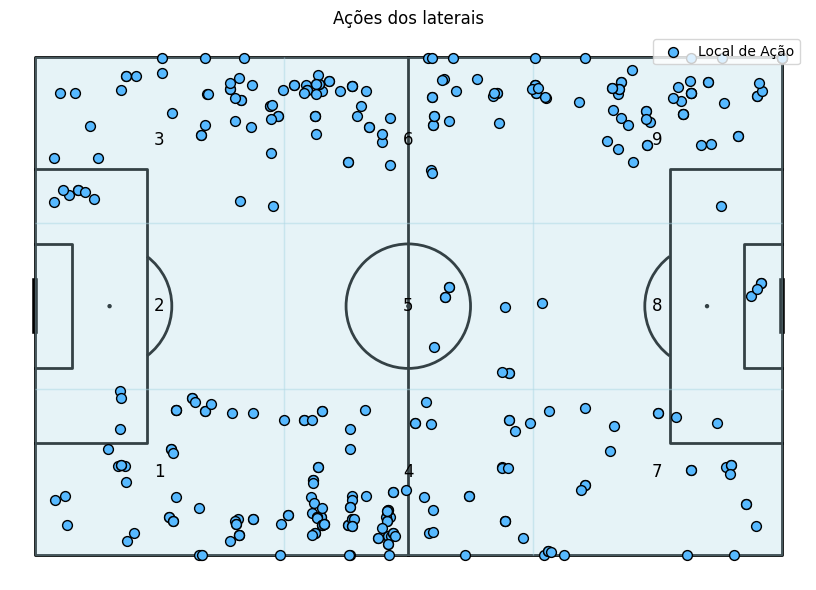

In [17]:
messi_actions = home_df[home_df["player_id"].isin([5507, 29201, 19597])]

pitch = Pitch(pitch_type="statsbomb", pitch_length=120, pitch_width=80, line_color="black")

fig, ax = pitch.draw(figsize=(10, 6))

regions = {
        1: {"xy": (0, 53.33), "width": 40, "height": 26.67}, 
        2: {"xy": (0, 26.67), "width": 40, "height": 26.67}, 
        3: {"xy": (0, 0), "width": 40, "height": 26.67},     
        
        4: {"xy": (40, 53.33), "width": 40, "height": 26.67},
        5: {"xy": (40, 26.67), "width": 40, "height": 26.67},
        6: {"xy": (40, 0), "width": 40, "height": 26.67},    
        
        7: {"xy": (80, 53.33), "width": 40, "height": 26.67}, 
        8: {"xy": (80, 26.67), "width": 40, "height": 26.67}, 
        9: {"xy": (80, 0), "width": 40, "height": 26.67}      
    }    


for i, region in regions.items():
    ax.add_patch(plt.Rectangle(**region, fill=True, color="lightblue", alpha=0.3, edgecolor="black"))
    
    # Add text for the classification and counts (optional, you can customize this part)
    center_x = region["xy"][0] + region["width"] / 2
    center_y = region["xy"][1] + region["height"] / 2
    ax.text(center_x, center_y, str(i), ha="center", va="center", fontsize=12, color="black")

ax.scatter(messi_actions["x"], messi_actions["y"], color="#57b9ff", edgecolors="black", s=50, label="Local de Ação")

plt.title("Ações dos laterais")
plt.legend(loc="upper right")

plt.show()


In [18]:
parser = Sbopen()
df, related, freeze, tactics = parser.event(3857300)

In [19]:
df = df[df.type_name == "Pass"]
df = df[["x", "y", "end_x", "end_y", "player_name", "pass_recipient_name","team_name","minute","player_id"]]
tactics = tactics[["jersey_number","player_id"]]

df_merged = pd.merge(df, tactics[["jersey_number", "player_id"]], on="player_id", how="left")

In [20]:
df_home_pass = df_merged[df_merged.team_name == hteam]

home_player_df = df_merged[df_merged.team_name == hteam].groupby("player_name").agg({"minute": [min, max]}).reset_index()
home_player_df = pd.concat([home_player_df["player_name"], home_player_df["minute"]], axis=1)
home_player_df["minutes_played"] = home_player_df["max"] - home_player_df["min"]
home_player_df = home_player_df.sort_values("minutes_played", ascending=False)

C:\Users\Tobi\AppData\Local\Temp\ipykernel_14992\1670289944.py:3: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  home_player_df = df_merged[df_merged.team_name == hteam].groupby("player_name").agg({"minute": [min, max]}).reset_index()
C:\Users\Tobi\AppData\Local\Temp\ipykernel_14992\1670289944.py:3: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  home_player_df = df_merged[df_merged.team_name == hteam].groupby("player_name").agg({"minute": [min, max]}).reset_index()


In [21]:
home_player_name = home_player_df.player_name[:14].tolist()
df_home_pass = df_home_pass[df_home_pass.player_name.isin(home_player_name)]
df_home_pass = df_home_pass[df_home_pass.pass_recipient_name.isin(home_player_name)]

In [22]:
scatter_df = pd.DataFrame()
for i, name in enumerate(df_home_pass["player_name"].unique()):
    passx = df_home_pass.loc[df_home_pass["player_name"] == name]["x"].to_numpy()
    recx = df_home_pass.loc[df_home_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_home_pass.loc[df_home_pass["player_name"] == name]["y"].to_numpy()
    recy = df_home_pass.loc[df_home_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name

    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))

    scatter_df.at[i, "no"] = df_home_pass.loc[df_home_pass["player_name"] == name].count().iloc[0]
    scatter_df.at[i, "jersey_number"] = df_home_pass.loc[df_home_pass["player_name"] == name]["jersey_number"].iloc[0]
    scatter_df["jersey_number"] = scatter_df["jersey_number"].astype(int)
    
scatter_df["marker_size"] = (scatter_df["no"] / scatter_df["no"].max() * 1500)

In [23]:
df_home_pass["pair_key"] = df_home_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = df_home_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({"x":"pass_count"}, axis="columns", inplace=True)

lines_df = lines_df[lines_df["pass_count"]>5]

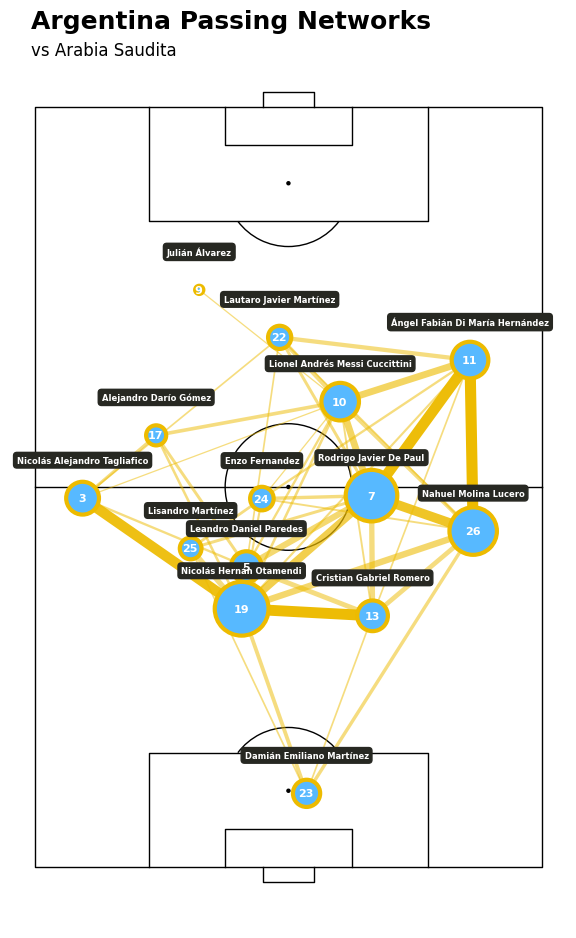

In [24]:
pitch = VerticalPitch(pitch_type="statsbomb", line_color="black",linewidth=1,goal_type="box")
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color="#57b9ff", edgecolors="#EDBB00", linewidth=3, alpha=1, ax=ax["pitch"], zorder = 3)

for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x +6, row.y), c="white", va="center",
                   ha="center", size=6, weight = "bold", ax=ax["pitch"], zorder = 4, 
                   bbox=dict(facecolor="#272822", alpha=1, edgecolor="#272822", boxstyle="round,pad=0.4"))
    
for i, row in scatter_df.iterrows():
    pitch.annotate(row.jersey_number, xy=(row.x, row.y-0.1), c="white", va="center",
                   ha="center", size=8, weight = "bold", ax=ax["pitch"], zorder = 4)

for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row["pair_key"].split("_")[1]
        #take the average location of players to plot a line between them
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]["x"].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]["y"].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]["x"].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]["y"].iloc[0]
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df["pass_count"].max() * 8)
        # adjust the alpha of the lines based on number of passes and set minimum alpha for a fewer pass
        alpha = max(num_passes / lines_df["pass_count"].max(), 0.2)
        alpha = max(alpha, 0.5)
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=alpha, lw=line_width, zorder=2, color="#EDBB00", ax = ax["pitch"])

fig.text(s=hteam + " "+ "Passing Networks", x= 0.06, y= 1, fontsize=18,fontweight="bold")
fig.text(s="vs Arabia Saudita", x = 0.06, y=0.97, fontsize=12)
plt.show()

## Cruzamentos

C:\Users\Tobi\AppData\Local\Temp\ipykernel_14992\1294002224.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cruzamentos_direito["outcome_name"] = cruzamentos_direito["outcome_name"].fillna("complete")


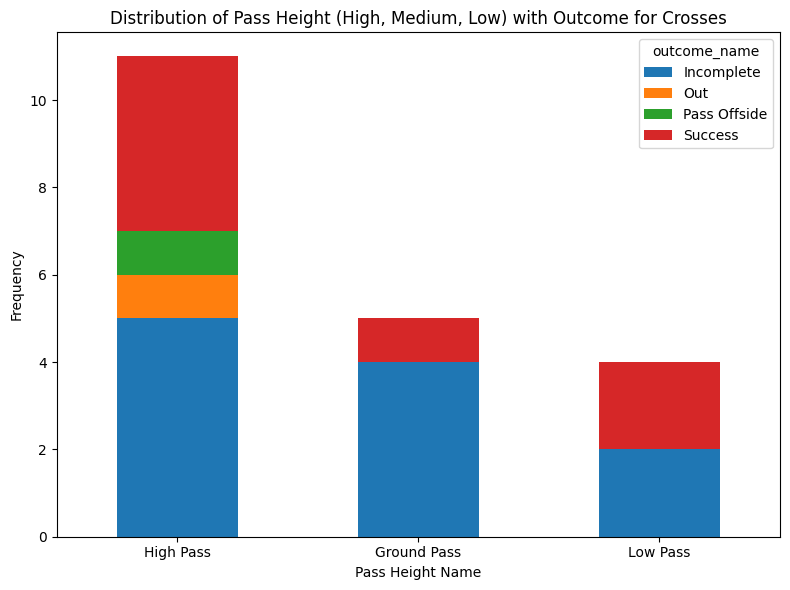

In [25]:
cruzamentos_direito = home_df[(home_df["type_name"] == "Pass") & 
                                     (home_df["pass_cross"] == True)]

cruzamentos_direito["outcome_name"] = cruzamentos_direito["outcome_name"].fillna("complete")

cross_tab = pd.crosstab(cruzamentos_direito["pass_height_name"], cruzamentos_direito["outcome_name"])

cross_tab = cross_tab.loc[cross_tab.sum(axis=1).sort_values(ascending=False).index]

cross_tab.plot(kind="bar", stacked=True, figsize=(8, 6), 
               color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"])  # Updated color palette
plt.title("Distribution of Pass Height (High, Medium, Low) with Outcome for Crosses")
plt.xlabel("Pass Height Name")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
